In [1]:
import matplotlib.pyplot as plt
import itertools
import numpy as np
import pandas as pd
from keras.utils.np_utils import to_categorical
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, load_model
from keras.datasets import mnist
import itertools
import random
import sys
sys.path.append('../')
from Core_Functions import neural_networks, generate_image_set

Using TensorFlow backend.


In [2]:
# Load data and split into training and test
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

In [3]:
# Split training set further into training and validation sets
sample_size = 40000
X_train, X_val, y_train, y_val = train_images[:sample_size], train_images[sample_size:sample_size*2],  train_labels[:sample_size], train_labels[sample_size:sample_size*2]

In [5]:
combo_train_X, combo_train_y = generate_image_set.get_image_combinations(40000, X_train, y_train)
combo_val_X, combo_val_y = generate_image_set.get_image_combinations(20000, X_val, y_val)

In [6]:
# Reshape the data so they can be fed into the network, one-hot-encode the labels

train_images = combo_train_X.reshape((combo_train_X.shape[0], 28*56,))
train_images = train_images/ 255

val_images = combo_val_X.reshape((combo_val_X.shape[0], 28*56,))
val_images = val_images/255

train_labels = to_categorical(combo_train_y)
val_labels = to_categorical(combo_val_y)

In [7]:
model = neural_networks.build_DNN(28*56)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 512)               803328    
_________________________________________________________________
dense_1 (Dense)              (None, 10)                5130      
Total params: 808,458
Trainable params: 808,458
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Fit model
model = neural_networks.build_DNN(28*56)
model.fit(train_images, 
          train_labels, 
          epochs = 20, 
          batch_size = 64)


In [71]:
# Print loss, mae and accuracy
eval_model = model.evaluate(val_images, val_labels)
eval_model

625/625 [==============================] - 1s 951us/step - loss: 0.5896 - accuracy: 0.9260 - mae: 0.0152


[0.589601993560791, 0.9259999990463257, 0.015237970277667046]

In [ ]:
# Perform k-fold cross-validation to understand the optimal number of epochs to train on
k = 4
num_val_samples = len(train_images)//k

num_epochs = 20

all_val_mae_histories = []
all_train_mae_histories = []

for i in range(k):
    
    print('processing fold #', i)
    val_data = train_images[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_labels[i * num_val_samples: (i + 1) * num_val_samples]
    
    partial_train_data = np.concatenate(
    [train_images[:i * num_val_samples],
    train_images[(i+1) * num_val_samples:]],
    axis = 0)
    
    partial_train_targets = np.concatenate(
    [train_labels[:i*num_val_samples],
    train_labels[(i+1)*num_val_samples:]],
    axis = 0)
    
    model = neural_networks.build_DNN(28*56)
    history = model.fit(partial_train_data,
              partial_train_targets,
              validation_data = (val_data, val_targets),
              epochs = num_epochs,
              batch_size = 64,
              verbose = 0)
    
    val_mae_history = history.history['val_mae']
    all_val_mae_histories.append(val_mae_history)
    
    train_mae_history = history.history['mae']
    all_train_mae_histories.append(train_mae_history)

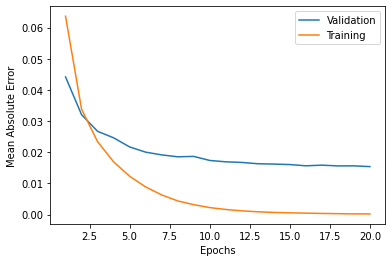

In [68]:
# Compute the average of the per-epoch MAE scores for all folds
# Building the history of successive mean K-fold validation scores

average_val_mae_history = [
    np.mean([x[i] for x in all_val_mae_histories]) for i in range(num_epochs)]

average_train_mae_history = [
    np.mean([x[i] for x in all_train_mae_histories]) for i in range(num_epochs)]

plt.plot(range(1, len(average_val_mae_history) + 1), average_val_mae_history, label='Validation')
plt.plot(range(1, len(average_train_mae_history) + 1), average_train_mae_history, label = 'Training')
plt.xlabel('Epochs')
plt.ylabel('Mean Absolute Error')
plt.legend()
plt.savefig('Q1_Figures/Q1_DNN.png', dpi = 400)

In [34]:
# serialize model to JSON
model_json = model.to_json()
with open("Q1_Trained_Models/DNN_Model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("Q1_Trained_Models/DNN_Model.h5")
print("Saved model to disk")

Saved model to disk


In [35]:
# Verify above by visually inspecting images from the predicted set
num_val_images = 10000

Predicted: 1
True: 1


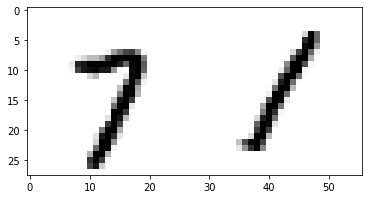

In [36]:
# Run this cell repeatedly to see multiple examples
check_index = random.randint(0,num_val_images)
plt.imshow(val_images[check_index].reshape(28,56), cmap = plt.cm.binary)
print("Predicted: " + str(np.argmax(y_predict[check_index])))
print("True: " + str(np.argmax(val_labels[check_index])))